# Лабаораторная работа №2: Классификация аудио

In [2]:
!apt install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 132 not upgraded.


In [4]:
# !pip -q install datasets torchaudio torch torchvision torchcodec scikit-learn transformers accelerate --upgrade.
# !pip install datasets[audio]
import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000


Device: cuda


In [5]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR))


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00016-e478d7cccca6a0(…):   0%|          | 0.00/434M [00:00<?, ?B/s]

data/train-00001-of-00016-299138aa39afaa(…):   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00002-of-00016-887e0748205b6f(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

data/train-00003-of-00016-691ee48aa53d9c(…):   0%|          | 0.00/447M [00:00<?, ?B/s]

data/train-00004-of-00016-c0f37514d8e28a(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00005-of-00016-55ef1a0a51149c(…):   0%|          | 0.00/591M [00:00<?, ?B/s]

data/train-00006-of-00016-0ef363072505e6(…):   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00007-of-00016-dfac173beb21e5(…):   0%|          | 0.00/588M [00:00<?, ?B/s]

data/train-00008-of-00016-2744487f32f65d(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00009-of-00016-83fc7364d47981(…):   0%|          | 0.00/549M [00:00<?, ?B/s]

data/train-00010-of-00016-4c1d0e285ed778(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00011-of-00016-79d186503a2667(…):   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00012-of-00016-6aff88fdcca229(…):   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00013-of-00016-17d827b1a5be04(…):   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00014-of-00016-c630762df85f6c(…):   0%|          | 0.00/381M [00:00<?, ?B/s]

data/train-00015-of-00016-03506887d89adf(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

In [6]:
def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8732 [00:00<?, ? examples/s]

(7079, 816, 837, 10)

In [7]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map:   0%|          | 0/7079 [00:00<?, ? examples/s]

Map:   0%|          | 0/816 [00:00<?, ? examples/s]

Map:   0%|          | 0/837 [00:00<?, ? examples/s]

LinearSVC  VAL acc: 0.5551470588235294
LinearSVC  TEST acc: 0.5077658303464755


In [8]:
class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

history = {
  "tr_loss": [],
  "tr_acc": [],
  "va_loss": [],
  "va_acc": [],
  "va_f1": []
}

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    preds_list = []
    trues_list = []
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1);
        correct += (pred==yb).sum().item();
        total += xb.size(0)

        preds_list.append(pred.cpu().numpy())
        trues_list.append(yb.cpu().numpy())

    preds = np.concatenate(preds_list)
    trues = np.concatenate(trues_list)
    return loss_sum/total, correct/total, trues, preds


epochs = 10
for ep in range(1, epochs + 1):
    tr_l, tr_a, _, _ = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, y_true_va, y_pred_va = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    va_f1 = f1_score(y_true_va, y_pred_va, average="macro")

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

    history["tr_loss"].append(tr_l)
    history["tr_acc"].append(tr_a)
    history["va_loss"].append(va_l)
    history["va_acc"].append(va_a)
    history["va_f1"].append(va_f1)

# Тест
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()

cnn_test_acc = accuracy_score(y_true, y_pred)
cnn_test_f1  = f1_score(y_true, y_pred, average="macro")
print("CNN TEST acc:", cnn_test_acc, "f1_macro:", cnn_test_f1)


Ep 01: train 1.4512/0.478 | valid 1.4548/0.529


Ep 02: train 0.9599/0.674 | valid 1.5109/0.526


Ep 03: train 0.7643/0.753 | valid 1.0416/0.714


Ep 04: train 0.6392/0.791 | valid 1.3193/0.651


Ep 05: train 0.5642/0.817 | valid 1.4552/0.657


Ep 06: train 0.4937/0.834 | valid 1.2080/0.716


Ep 07: train 0.4323/0.861 | valid 1.7406/0.598


Ep 08: train 0.4275/0.860 | valid 1.4362/0.679


Ep 09: train 0.3698/0.876 | valid 1.4377/0.659


Ep 10: train 0.3546/0.884 | valid 1.8248/0.645


CNN TEST acc: 0.6379928315412187 f1_macro: 0.6631884051901613


In [8]:
MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b:
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()
print("AST VALID:", trainer.evaluate(va_ast))
print("AST TEST :", trainer.evaluate(te_ast))


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map: 100%|##########| 7079/7079 [00:00<?, ? examples/s]

Map: 100%|##########| 816/816 [00:00<?, ? examples/s]

Map: 100%|##########| 837/837 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sypoo (sypoo-yandex-mtuci) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.279100,0.963415,0.841912,0.851664
2,0.145700,1.052723,0.822304,0.845159
3,0.050200,0.858564,0.875000,0.889229
4,0.023900,1.010764,0.875000,0.880087
5,0.036800,0.920963,0.894608,0.907386
6,0.021500,1.140755,0.886029,0.898344
7,0.007600,1.195444,0.876225,0.886370
8,0.004200,0.982324,0.898284,0.910655
9,0.005800,0.952119,0.901961,0.912239
10,0.000000,1.010710,0.899510,0.910086


AST VALID: {'eval_loss': 1.0107097625732422, 'eval_accuracy': 0.8995098039215687, 'eval_f1_macro': 0.9100857964727755, 'eval_runtime': 40.8975, 'eval_samples_per_second': 19.952, 'eval_steps_per_second': 2.494, 'epoch': 10.0}
AST TEST : {'eval_loss': 1.1151050329208374, 'eval_accuracy': 0.8829151732377539, 'eval_f1_macro': 0.8927181180181092, 'eval_runtime': 43.1942, 'eval_samples_per_second': 19.378, 'eval_steps_per_second': 2.431, 'epoch': 10.0}


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [ ]:
ast_metrics_val = trainer.evaluate(va_ast)
ast_metrics_test = trainer.evaluate(te_ast)

In [11]:
ast_metrics_val, ast_metrics_test

({'eval_loss': 1.0107097625732422,
  'eval_accuracy': 0.8995098039215687,
  'eval_f1_macro': 0.9100857964727755,
  'eval_runtime': 45.7686,
  'eval_samples_per_second': 17.829,
  'eval_steps_per_second': 2.229,
  'epoch': 10.0},
 {'eval_loss': 1.1151050329208374,
  'eval_accuracy': 0.8829151732377539,
  'eval_f1_macro': 0.8927181180181092,
  'eval_runtime': 41.8137,
  'eval_samples_per_second': 20.017,
  'eval_steps_per_second': 2.511,
  'epoch': 10.0})

In [25]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST
# Подставьте ваши значения метрик. Если их нет — посчитайте/извлеките выше.
# Требуемые поля: cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1
#                 ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1

import pandas as pd

# --- Пример: замените None на ваши переменные/числа ---
cnn_val_acc  = history["va_acc"][-1]
cnn_val_f1   = history["va_f1"][-1]
cnn_test_acc = cnn_test_acc
cnn_test_f1  = cnn_test_f1

ast_val_acc  = ast_metrics_val['eval_accuracy']
ast_val_f1   = ast_metrics_val['eval_f1_macro']
ast_test_acc = ast_metrics_test['eval_accuracy']
ast_test_f1  = ast_metrics_test['eval_f1_macro']


results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results


,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.644608,0.663101,0.637993,0.663188
1,AST FT,0.899510,0.910086,0.882915,0.892718


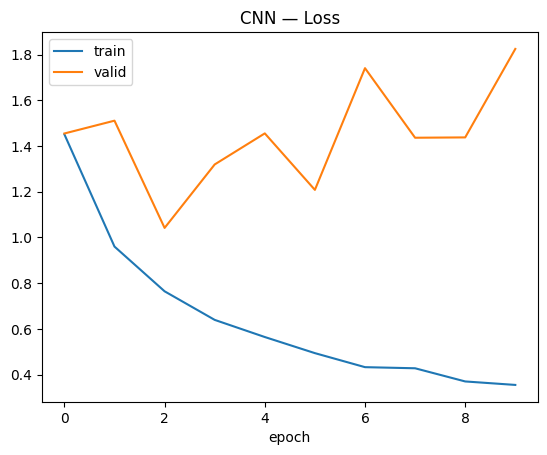

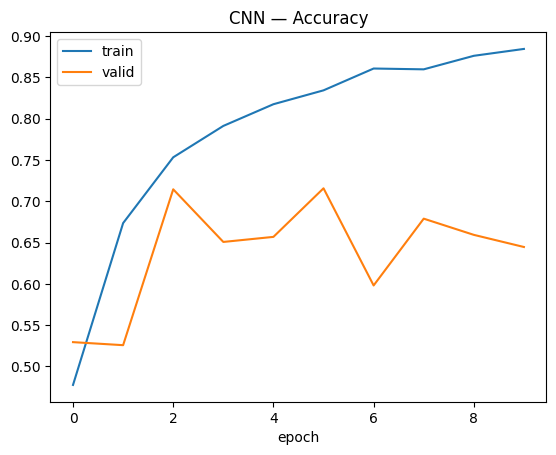

In [26]:
# TODO(1.2): Графики обучения CNN (loss/acc по эпохам)
#  Логгируйте значения из вашего цикла обучения.

import matplotlib.pyplot as plt

# Пример построения (раскомментируйте и подставьте):
plt.figure(); plt.plot(history["tr_loss"]); plt.plot(history["va_loss"]);
plt.title("CNN — Loss"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()
plt.figure(); plt.plot(history["tr_acc"]); plt.plot(history["va_acc"]);
plt.title("CNN — Accuracy"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()


## Задание 2. Эксперимент (выберите один вариант)

**Вариант A:** добавить SpecAugment в обучение CNN.  
**Вариант B:** изменить параметры мел-спектрограмм (например, `N_MELS`, `HOP`, `N_FFT`) и переобучить CNN.

Оформите гипотезу → что меняете → метрики ДО/ПОСЛЕ → краткий вывод.


In [20]:
# TODO(2.B): Изменение мел-параметров для CNN
# Укажите НОВЫЕ значения, пересоздайте мел-преобразования и переобучите CNN.

N_MELS_NEW = 40    # было 64
HOP_NEW    = 182   # было 256
N_FFT_NEW  = 2048  # было 1024

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT_NEW, hop_length=HOP_NEW,
                           n_mels=N_MELS_NEW, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)

model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

epochs_new = 10
history_new = {"tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[], "va_f1":[]}

for ep in range(1, epochs_new + 1):
    tr_l, tr_a, _, _ = run_epoch(train_loader, True, f"train_new {ep}/{epochs_new}")
    va_l, va_a, y_true_va, y_pred_va = run_epoch(val_loader, False, f"valid_new {ep}/{epochs_new}")
    va_f1 = f1_score(y_true_va, y_pred_va, average="macro")

    history_new["tr_loss"].append(tr_l)
    history_new["tr_acc"].append(tr_a)
    history_new["va_loss"].append(va_l)
    history_new["va_acc"].append(va_a)
    history_new["va_f1"].append(va_f1)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f} | valid f1 {va_f1:.4f}")


model.eval()
y_true_after, y_pred_after = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test_after", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true_after += yb.numpy().tolist()
        y_pred_after += logits.argmax(1).cpu().numpy().tolist()

test_acc_after = accuracy_score(y_true_after, y_pred_after)
test_f1_after  = f1_score(y_true_after, y_pred_after, average="macro")

Ep 01: train 1.5159/0.454 | valid 1.3800/0.517 | valid f1 0.5175


Ep 02: train 1.0040/0.657 | valid 1.6090/0.534 | valid f1 0.5397


Ep 03: train 0.8254/0.722 | valid 1.4731/0.534 | valid f1 0.5142


Ep 04: train 0.7022/0.768 | valid 1.5786/0.526 | valid f1 0.5410


Ep 05: train 0.6307/0.787 | valid 2.0878/0.518 | valid f1 0.5515


Ep 06: train 0.5471/0.816 | valid 1.7075/0.627 | valid f1 0.6366


Ep 07: train 0.5059/0.829 | valid 1.4447/0.645 | valid f1 0.6642


Ep 08: train 0.4589/0.843 | valid 1.4651/0.664 | valid f1 0.6710


Ep 09: train 0.4244/0.856 | valid 1.4747/0.621 | valid f1 0.6404


Ep 10: train 0.3761/0.873 | valid 1.5736/0.607 | valid f1 0.6537


In [23]:
import pandas as pd

results = pd.DataFrame([
    ["Old: CNN (N_MELS={}, HOP={}, N_FFT={})".format(N_MELS, HOP, N_FFT), round(history["va_acc"][-1],4), round(history["va_f1"][-1],4), round(cnn_test_acc,4), round(cnn_test_f1,4)],
    ["New: CNN (N_MELS={}, HOP={}, N_FFT={})".format(N_MELS_NEW, HOP_NEW, N_FFT_NEW),
     round(history_new["va_acc"][-1],4), round(history_new["va_f1"][-1],4), round(test_acc_after,4), round(test_f1_after,4)]
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

display(results)

if test_f1_after > cnn_test_f1:
    print(f"F1 улучшился на тесте: {cnn_test_f1:.4f} -> {test_f1_after:.4f}. Новые мел-параметры помогли.")
elif test_f1_after < cnn_test_f1:
    print(f"F1 ухудшился на тесте: {cnn_test_f1:.4f} -> {test_f1_after:.4f}. Новые мел-параметры ухудшили результат.")
else:
    print(f"F1 не изменился на тесте: {cnn_test_f1:.4f} -> {test_f1_after:.4f}.")


,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,"Old: CNN (N_MELS=64, HOP=256, N_FFT=1024)",0.6446,0.6631,0.6380,0.6632
1,"New: CNN (N_MELS=40, HOP=182, N_FFT=2048)",0.6066,0.6537,0.6022,0.6322


F1 ухудшился на тесте: 0.6632 -> 0.6322. Новые мел-параметры ухудшили результат.


## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


In [ ]:
# TODO(3): Инференс AST на своём .wav
# Требуются: processor, ast (обученная модель), SR, id2label

import soundfile as sf

def ast_predict_wav(path, top_k=3):
    # 1) загрузка .wav
    wav, sr = sf.read(path)
    wav = wav.astype(np.float32)

    # 2) ресемплинг при несоответствии частоты
    #TODO

    # 3) препроцессинг
    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    # 4) инференс
    ast.eval()
    with torch.no_grad():
        logits = ast(**inputs).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    # 5) топ-K
    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()
    return [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

# Пример:
# ast_predict_wav("my_audio.wav", top_k=5)
